In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tensorboard
from torch.utils.tensorboard import SummaryWriter

/home/shah/miniconda3/envs/rtx_3060/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torch.cuda.is_available()

In [ ]:
torch.zeros(1).cuda()

In [2]:
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 40330), started 0:57:46 ago. (Use '!kill 40330' to kill it.)

In [3]:
cudnn.benchmark = True
plt.ion()   # interactive mode
write = SummaryWriter()

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ])
}

path_dir = '/home/shah/Desktop/FB-Marketplace-Recommendation-Ranking-System/data/data_images/'

image_datasets = {
    'train': 
    datasets.ImageFolder(path_dir + 'train', data_transforms['train']),
    'val': 
    datasets.ImageFolder(path_dir + 'val', data_transforms['val']),
    'test': 
    datasets.ImageFolder(path_dir + 'test', data_transforms['test']),
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=4,
                                shuffle=True,
                                num_workers=0), 
    'val':
    torch.utils.data.DataLoader(image_datasets['val'],
                                batch_size=4,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=4,
                                shuffle=False,
                                num_workers=0),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
#class_names = {k: v for v, k in enumerate(class_names)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [ ]:
class_names

In [ ]:
image_datasets['train']

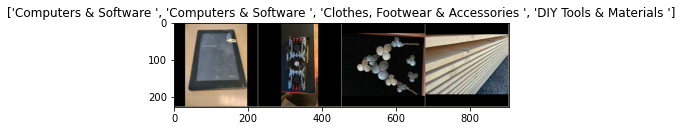

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                print("training in progress")
                model.train()  # Set model to training mode
            else:
                print("validating in progress")
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            counter = 0
            hund_loss = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #time to carry out the forward training poss
                with torch.set_grad_enabled(phase == 'train'):
                    counter += 1
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    hund_loss += loss.item()
                    if counter % 100 == 0:
                        print(f'{phase} Round {epoch} of {num_epochs} loss: {(hund_loss / 100)} Running corrects: {running_corrects} Batch No: {counter}')
                        writer.add_scalar('Training Loss', (hund_loss / 100), time.time())
                        hund_loss = 0

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #variables to hold the loss/acc statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            #saving variable for plottin
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / (counter * 4) 
            writer.add_scalar('Epoch Accuracy', epoch_acc, time.time())

            print(f'Phase: {phase} -- Loss: {epoch_loss:.4f} -- Acc: {(epoch_acc * 100):.1f}%')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save the model to file
                

        print()

    time_elapsed = time.time() - since
    print(f'Training model took {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Overall Val Acc is: {(best_acc * 100):.1f}%')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/home/shah/Desktop/FB-Marketplace-Recommendation-Ranking-System/data/model_state_dict.pt')
    return model

In [6]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [7]:
def test_model(model, len_labels):

    # Load the model that we saved at the end of the training loop   
     
    labels_length = len_labels
    labels_correct = list(0. for i in range(labels_length)) # list to calculate correct labels
    labels_total = list(0. for i in range(labels_length))   # list to keep the total # of labels per type
  
    with torch.no_grad(): 
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) 
             
            label_correct_running = (preds == outputs).squeeze() 
            label = outputs[0] 
            if label_correct_running.item():  
                labels_correct[label] += 1 
            labels_total[label] += 1  
  
    label_list = list(labels.keys()) 
    for i in range(labels_length): 
        print("THIS IS NEW! IF YOU SEE THIS, YOU ARE GOOD")
        print('Accuracy to predict %5s : %2d %%' % (label_list[i], 100 * labels_correct[i] / labels_total[i])) 

Epoch 0/19
----------
training in progress
train Rnd 0 of 20 loss: 2.5728742837905885 Running corrects: 68 Batch No: 100
train Rnd 0 of 20 loss: 2.388551651239395 Running corrects: 166 Batch No: 200
train Rnd 0 of 20 loss: 2.3155682361125947 Running corrects: 261 Batch No: 300
train Rnd 0 of 20 loss: 2.302806559801102 Running corrects: 379 Batch No: 400
train Rnd 0 of 20 loss: 2.348628904223442 Running corrects: 489 Batch No: 500
train Rnd 0 of 20 loss: 2.236149845123291 Running corrects: 599 Batch No: 600
train Rnd 0 of 20 loss: 2.171597982645035 Running corrects: 728 Batch No: 700
train Rnd 0 of 20 loss: 2.3274942809343337 Running corrects: 830 Batch No: 800
train Rnd 0 of 20 loss: 2.1315844321250914 Running corrects: 969 Batch No: 900
train Rnd 0 of 20 loss: 2.0456626409292222 Running corrects: 1101 Batch No: 1000
train Rnd 0 of 20 loss: 2.12253109395504 Running corrects: 1239 Batch No: 1100
train Rnd 0 of 20 loss: 2.3280260622501374 Running corrects: 1345 Batch No: 1200
train Rnd 0

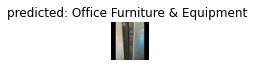

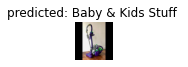

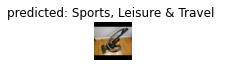

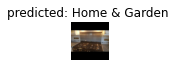

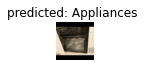

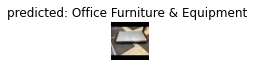

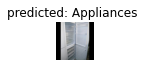

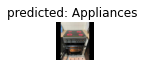

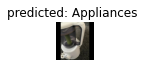

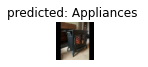

RuntimeError: The size of tensor a (4) must match the size of tensor b (13) at non-singleton dimension 1

In [8]:
writer = SummaryWriter()
file_name1 = "current_model"
model_ft = models.resnet50(pretrained=True) #Fine tune model
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)


#model_ft = models.resnet50(pretrained=True).to(device)

#for param in model_ft.parameters():
#    param.requires_grad = False
#model_ft.fc = nn.Sequential(
#    nn.Linear(2048, 128),
#    nn.ReLU(inplace=True),
#    nn.Linear(128, 13)).to(device)
#model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

visualize_model(model_ft)
input("visualizing model")
test_model(model_ft, len(class_names))
writer.flush()
plt.ioff()
plt.show()

In [ ]:
#To save the model
#torch.save(model_ft, "data/image_model.pt")

#To load the model
#torch.load("data/image_model.pt")
#model.eval()

